In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Useful constants

In [2]:
data_dir = "../simulations/"

In [3]:
n_samples = 100
x = np.arange(1, n_samples//2 + 1) / n_samples
sfs_neut = (1/x + 1/(1-x)) / n_samples
pi_weight = 2*x*(1-x)
print(x)
print(pi_weight)

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12
  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24
  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36
  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48
  0.49  0.5 ]
[ 0.0198  0.0392  0.0582  0.0768  0.095   0.1128  0.1302  0.1472  0.1638
  0.18    0.1958  0.2112  0.2262  0.2408  0.255   0.2688  0.2822  0.2952
  0.3078  0.32    0.3318  0.3432  0.3542  0.3648  0.375   0.3848  0.3942
  0.4032  0.4118  0.42    0.4278  0.4352  0.4422  0.4488  0.455   0.4608
  0.4662  0.4712  0.4758  0.48    0.4838  0.4872  0.4902  0.4928  0.495
  0.4968  0.4982  0.4992  0.4998  0.5   ]


In [4]:
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
print(r_list)

[  0.00000000e+00   1.00000000e-01   2.15443469e-01   4.64158883e-01
   1.00000000e+00   2.15443469e+00   4.64158883e+00   1.00000000e+01
   2.15443469e+01   4.64158883e+01   1.00000000e+02   2.15443469e+02
   4.64158883e+02   1.00000000e+03]


## Helper functions

In [5]:
def pmi(mSFS, jSFS):
    mSFS_sq = mSFS[:,None,:] * mSFS[:,:,None]
    return np.log2(jSFS / mSFS_sq)

In [6]:
def import_sfs(file_list, n_samples):
    n_files = len(file_list)
    mSFS = np.zeros((n_files, n_samples-1))
    jSFS_triu = np.zeros((n_files, n_samples*(n_samples-1)//2))
    
    # Import data from files
    for i, f in enumerate(file_list):
        with open(f) as datafile:
            for line in datafile:
                # Skip header lines
                if line.startswith('#'):
                    continue
                # First two non-header lines contain the marginal and joint SFS
                mSFS[i,:] = np.array(line.split(), dtype=float)
                jSFS_triu[i,:] = np.array(datafile.readline().split())
                break
                
    # Unpack the joint SFS
    jSFS = np.zeros((n_files, n_samples-1, n_samples-1))
    for i in range(n_files):
        jSFS[i,:,:][np.triu_indices(n_samples-1)] = jSFS_triu[i,:]
        # Don't double-count the diagonal values
        jSFS[i,:,:][np.diag_indices(n_samples-1)] /= 2
    # Symmetrize distribution
    jSFS += np.transpose(jSFS, axes=(0,2,1))
    
    # Fold marginal and joint SFS.
    mSFS_fold = (mSFS + mSFS[:,::-1])[:,:n_samples//2]
    jSFS_fold = (jSFS + jSFS[:,::-1,:] + jSFS[:,:,::-1] + jSFS[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
    # Don't double-count the n/2 = n - n/2 values.
    if n_samples % 2 == 0:
        mSFS_fold[:,-1] /= 2
        jSFS_fold[:,-1,:-1] /= 2
        jSFS_fold[:,:-1,-1] /= 2
        jSFS_fold[:,-1,-1] /= 4

    pi = np.dot(mSFS_fold, pi_weight)
    PMI = pmi(mSFS_fold, jSFS_fold)
    wPMI = PMI * jSFS_fold
    diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
    offdiag = np.sum(wPMI, axis=(1,2)) - diag

    return pi, mSFS_fold, jSFS_fold, PMI, wPMI, diag, offdiag

## Constant-$N$ Kingman

Import SFS data.

In [7]:
file_list = [data_dir + 'jsfs_a-2.0_r-{}.txt'.format(r) for r in r_list]
pi_k, mSFS_k, jSFS_k, PMI_k, wPMI_k, diag_k, offdiag_k = import_sfs(file_list, n_samples)

Calculate $\pi(r)$, which should be independent of the recombination rate.

In [8]:
print(pi_k)

[ 1.97984264  1.9797683   1.97754926  1.98272966  1.98210526  1.98166954
  1.98094112  1.9815702   1.97896617  1.9827001   1.98249799  1.98372225
  1.97812777  1.97753019]


Plot the marginal SFS against the theoretical expectation. The SFS should be independent of the recombination rate.

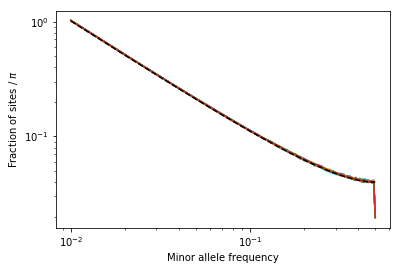

In [9]:
plt.loglog(x, mSFS_k.T/pi_k[None,:])
plt.loglog(x, sfs_neut, 'k--')
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')

Plot the joint SFS of the perfectly-linked case as a heatmap.

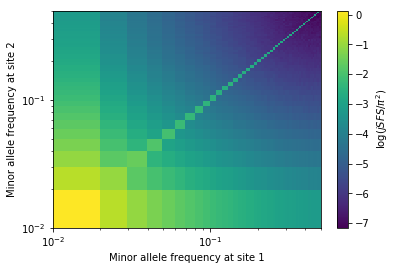

In [10]:
plt.pcolor(x, x, np.log(jSFS_k[0,:,:]/pi_k[0]**2))
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='$\log(jSFS/\pi^2)$')
plt.xlabel('Minor allele frequency at site 1')
plt.ylabel('Minor allele frequency at site 2')

Note two trends: Enrichment along the diagonal fall-off with higher frequency. We can eliminate the later by calculating the pointwise mutual information (PMI), which measures enrichment in the joint distribution relative to the product of marginal distributions.

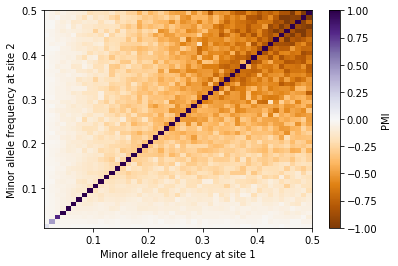

In [34]:
plt.pcolor(x, x, PMI_k[0,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
#plt.yscale('log')
#plt.xscale('log')
plt.colorbar(label='PMI')
plt.xlabel('Minor allele frequency at site 1')
plt.ylabel('Minor allele frequency at site 2')
plt.show()

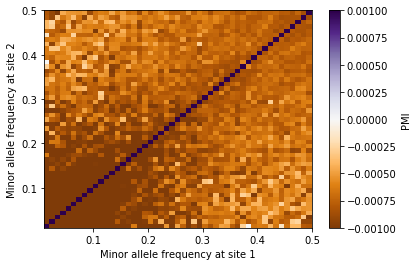

In [35]:
plt.pcolor(x, x, wPMI_k[0,:,:]/pi_k[0]**2,
            vmin=-.001, vmax=.001, cmap='PuOr')
#plt.yscale('log')
#plt.xscale('log')
plt.colorbar(label='PMI')
plt.xlabel('Minor allele frequency at site 1')
plt.ylabel('Minor allele frequency at site 2')
plt.show()

This clarifies the enrichment along the diagonal and depletion of off-diagonal elements.

How does the pattern change with increasing recombination rate?

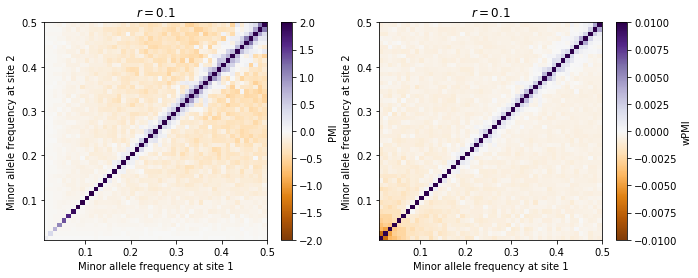

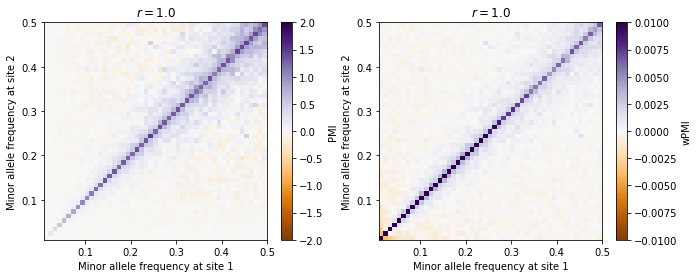

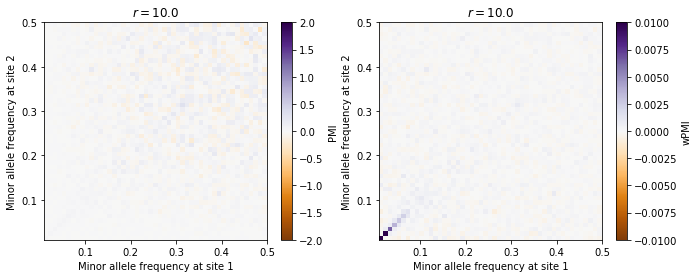

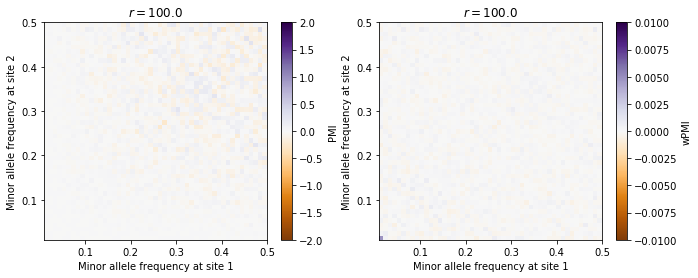

In [33]:
for r in [0.1, 1.0, 10.0, 100.0]:
    plt.figure(figsize=(11,4))
    i = list(r_list).index(r)
    plt.subplot(121)
    plt.pcolor(x, x, PMI_k[i,:,:],
            vmin=-2, vmax=2, cmap='PuOr')
    #plt.yscale('log')
    #plt.xscale('log')
    plt.colorbar(label='PMI')
    plt.xlabel('Minor allele frequency at site 1')
    plt.ylabel('Minor allele frequency at site 2')
    plt.title(r'$r = {}$'.format(r))
    
    plt.subplot(122)
    plt.pcolor(x, x, wPMI_k[i,:,:]/pi_k[i]**2,
            vmin=-.01, vmax=.01, cmap='PuOr')
    #plt.yscale('log')
    #plt.xscale('log')
    plt.colorbar(label='wPMI')
    plt.xlabel('Minor allele frequency at site 1')
    plt.ylabel('Minor allele frequency at site 2')
    plt.title(r'$r = {}$'.format(r))


    plt.show()

The diagonal elements decay to zero. On the other hand, the off-diagonal elements go positive at low, but positive, recombination rate and then decay to zero. The recombination rate scale of this decay is $r=1$.

We can summarize these effects with sums of the diagonal and off-diagonal elements, weighted by the joint distribution as in standard mutual information:

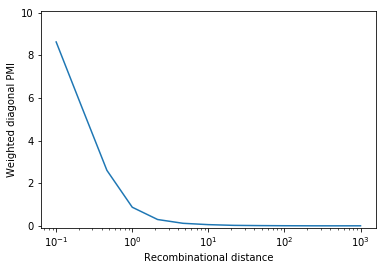

In [19]:
plt.semilogx(r_list, diag_k/pi_k**2)
plt.ylim([-0.1,10.1])
plt.ylabel('Weighted diagonal PMI')
plt.xlabel('Recombinational distance')

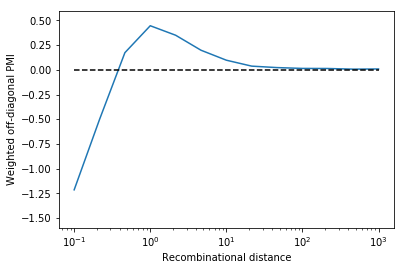

In [20]:
plt.semilogx(r_list, offdiag_k/pi_k**2)
plt.semilogx(r_list, np.zeros_like(r_list), '--k')
plt.ylim([-1.6,0.6])
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance')

# Import data

## Beta coalescents

In [23]:
a_list = [2.0, 1.75, 1.5, 1.25]

pi_beta = []
mSFS_beta = []
jSFS_beta = []
PMI_beta = []
wPMI_beta = []
diag_beta = []
offdiag_beta = []
for a in a_list:
    file_list = [data_dir + 'jsfs_a-{}_r-{}.txt'.format(a,r) for r in r_list[:-3]]
    results = import_sfs(file_list, n_samples)

    pi_beta.append(results[0])
    mSFS_beta.append(results[1])
    jSFS_beta.append(results[2])
    PMI_beta.append(results[3])
    wPMI_beta.append(results[4])
    diag_beta.append(results[5])
    offdiag_beta.append(results[6])

## Exponential growth

In [38]:
g_list = [1.0, 2.0, 4.0, 8.0]

pi_exp = []
mSFS_exp = []
jSFS_exp = []
PMI_exp = []
wPMI_exp = []
diag_exp = []
offdiag_exp = []
for g in g_list:
    file_list = [data_dir + 'jsfs_g-{}_r-{}.txt'.format(g,r) for r in r_list[:-3]]
    results = import_sfs(file_list, n_samples)

    pi_exp.append(results[0])
    mSFS_exp.append(results[1])
    jSFS_exp.append(results[2])
    PMI_exp.append(results[3])
    wPMI_exp.append(results[4])
    diag_exp.append(results[5])
    offdiag_exp.append(results[6])

## Piecewise-constant growth

In [167]:
t_list = [0.01, 0.1, 1.0]
#s_list = [0.01, 0.05, 0.1]
s_list = [0.2, 0.1, 0.05, 0.01]
pi_pwc = []
mSFS_pwc = []
jSFS_pwc = []
PMI_pwc = []
wPMI_pwc = []
diag_pwc = []
offdiag_pwc = []
for t in t_list:
    for s in s_list:
        file_list = [data_dir + 'jsfs_T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in r_list]
        #file_list = [data_dir + 'jsfs_T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in r_list[:-3]]

        results = import_sfs(file_list, n_samples)

        pi_pwc.append(results[0])
        mSFS_pwc.append(results[1])
        jSFS_pwc.append(results[2])
        PMI_pwc.append(results[3])
        wPMI_pwc.append(results[4])
        diag_pwc.append(results[5])
        offdiag_pwc.append(results[6])

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


# Marginal Site Frequency Spectra

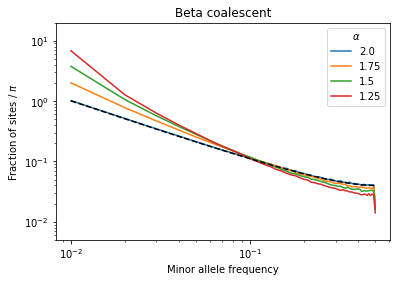

In [64]:
for i,a in enumerate(a_list):
    plt.loglog(x, mSFS_beta[i][0,:]/pi_beta[i][0], label=a)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$\alpha$')
plt.title('Beta coalescent')

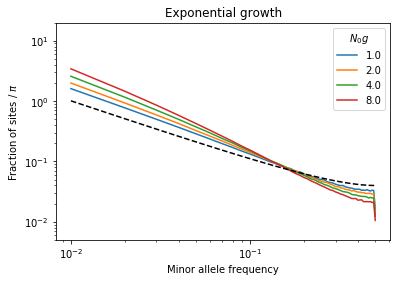

In [65]:
for i,g in enumerate(g_list):
    plt.loglog(x, mSFS_exp[i][0,:]/pi_exp[i][0], label=g)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))


plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$N_0g$')
plt.title('Exponential growth')

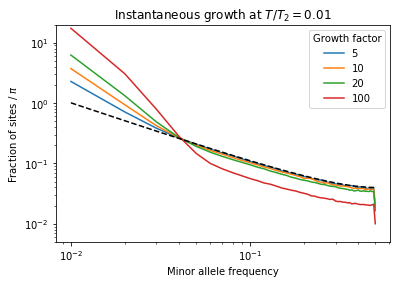

In [196]:
for i in range(4):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'Growth factor')
plt.title('Instantaneous growth at $T/T_2 = 0.01$')

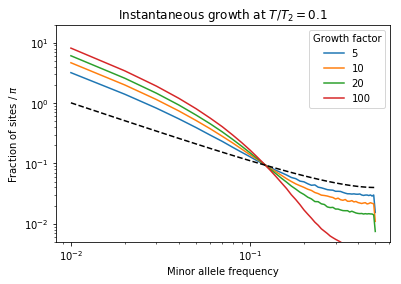

In [197]:
for i in range(4,8):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'Growth factor')
plt.title('Instantaneous growth at $T/T_2 = 0.1$')

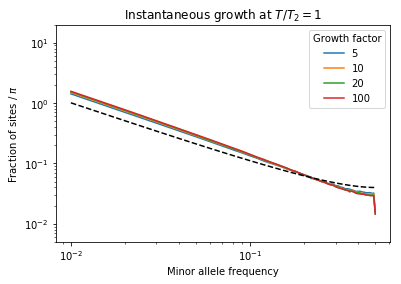

In [198]:
for i in range(8,12):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'Growth factor')
plt.title('Instantaneous growth at $T/T_2 = 1$')

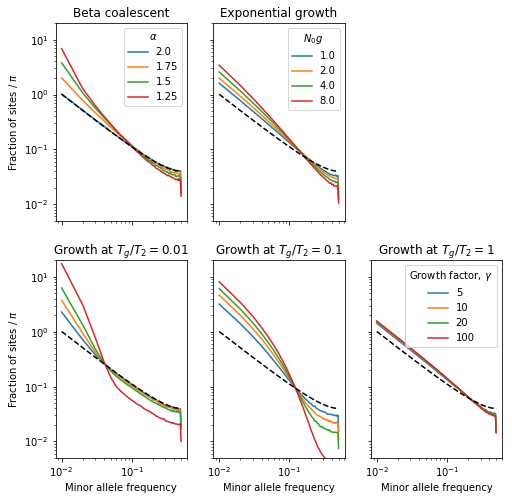

In [345]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2, 3, 1)
for i,a in enumerate(a_list):
    plt.loglog(x, mSFS_beta[i][0,:]/pi_beta[i][0], label=a)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
#plt.xlabel('Minor allele frequency')
ax.set_xticklabels([])
plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$\alpha$')
plt.title('Beta coalescent')

ax = fig.add_subplot(2, 3, 2)
for i,g in enumerate(g_list):
    plt.loglog(x, mSFS_exp[i][0,:]/pi_exp[i][0], label=g)
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
ax.set_yticklabels([])
ax.set_xticklabels([])
#plt.xlabel('Minor allele frequency')
#plt.ylabel('Fraction of sites / $\pi$')
plt.legend(title=r'$N_0g$')
plt.title('Exponential growth')

fig.add_subplot(2, 3, 4)
for i in range(4):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
plt.ylabel('Fraction of sites / $\pi$')
#plt.legend(title=r'Growth factor')
plt.title('Growth at $T_g/T_2 = 0.01$')

ax = fig.add_subplot(2, 3, 5)
for i in range(4,8):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
#plt.ylabel('Fraction of sites / $\pi$')
#plt.legend(title=r'Growth factor')
ax.set_yticklabels([])
plt.title('Growth at $T_g/T_2 = 0.1$')

ax = fig.add_subplot(2,3,6)
for i in range(8,12):
    plt.loglog(x, mSFS_pwc[i][0,:]/pi_pwc[i][0], label=int(1.0/s_list[i%4]))
plt.loglog(x, sfs_neut, 'k--')
plt.ylim((.005,20))
plt.xlabel('Minor allele frequency')
#plt.ylabel('Fraction of sites / $\pi$')
ax.set_yticklabels([])
plt.legend(title=r'Growth factor, $\gamma$')
plt.title('Growth at $T_g/T_2 = 1$')

plt.savefig('../manuscript/figures/mSFS.pdf')

# 2-site frequency spectra

In [104]:
pmi_max = 1
wpmi_max = 0.005

## Non-recombining loci

Beta coalescent.

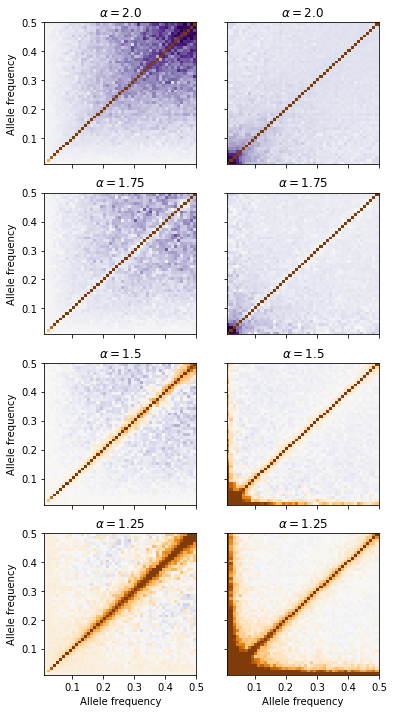

In [366]:
fig = plt.figure(figsize=(6, 12))
for i_a, a in enumerate(a_list):
    ax = fig.add_subplot(4, 2, 2*i_a + 1)
    ax.pcolormesh(x, x, PMI_beta[i_a][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
    ax.set_title(r'$\alpha=${}'.format(a))
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylabel('Allele frequency')
    if i_a<3:
        ax.set_xticklabels([])
        #ax.set_yticks([])
    else:
        ax.set_xlabel('Allele frequency')

    
    ax = fig.add_subplot(4, 2, 2*i_a + 2)
    ax.pcolormesh(x, x, wPMI_beta[i_a][0,:,:]/pi_beta[i_a][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
    ax.set_title(r'$\alpha=${}'.format(a))
    ax.set_yticklabels([])
    if i_a<3:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Allele frequency')

plt.savefig('../manuscript/figures/pmi_beta_r0.pdf')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

Kingman with exponential growth.

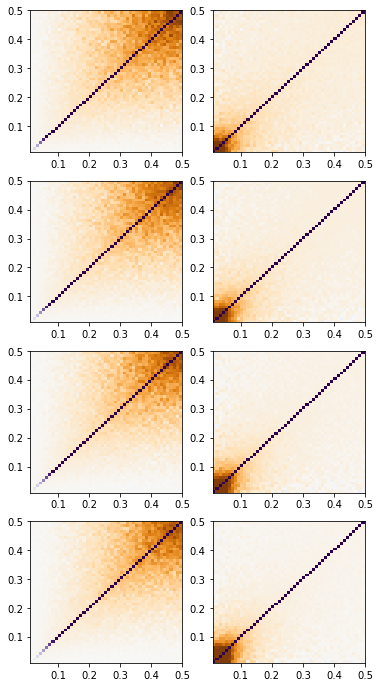

In [180]:
fig = plt.figure(figsize=(6, 12))
for i_g, g in enumerate(g_list):
    ax = fig.add_subplot(4, 2, 2*i_g + 1)
    ax.pcolormesh(x, x, PMI_exp[i_g][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*i_g + 2)
    ax.pcolormesh(x, x, wPMI_exp[i_g][0,:,:]/pi_exp[i_g][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

Kingman with instantaneous growth.

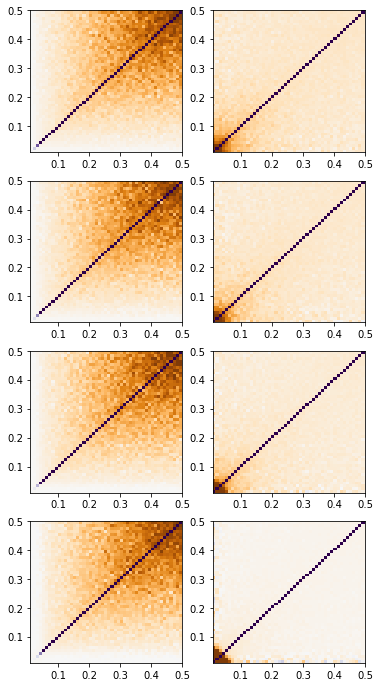

In [177]:
fig = plt.figure(figsize=(6, 12))
for i in range(4):
    ax = fig.add_subplot(4, 2, 2*i + 1)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*i + 2)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

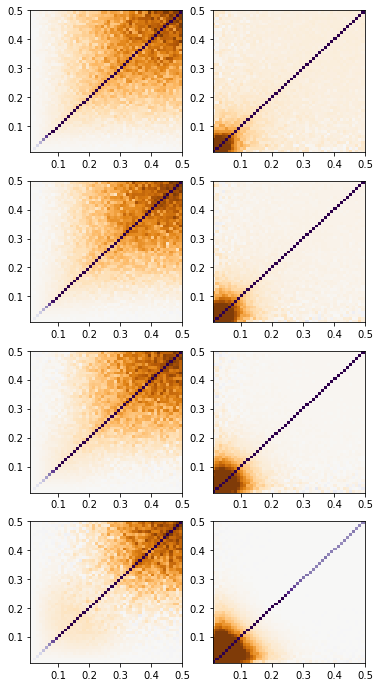

In [181]:
fig = plt.figure(figsize=(6, 12))
for i in range(4,8):
    ax = fig.add_subplot(4, 2, 2*(i%4) + 1)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*(i%4) + 2)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

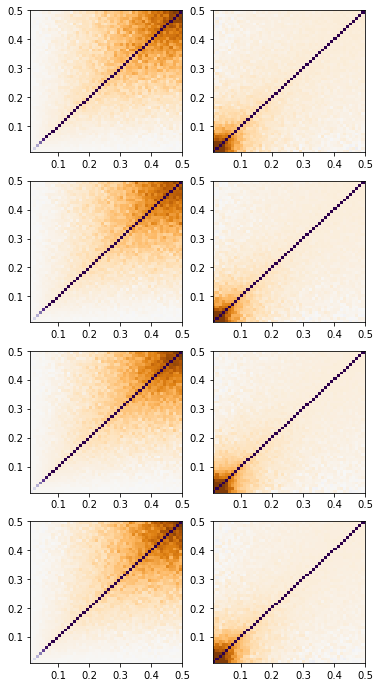

In [184]:
fig = plt.figure(figsize=(6, 12))
for i in range(8,12):
    ax = fig.add_subplot(4, 2, 2*(i%4) + 1)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])
    
    ax = fig.add_subplot(4, 2, 2*(i%4) + 2)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xticks([])
    #ax.set_yticks([])

Combined figure PMI

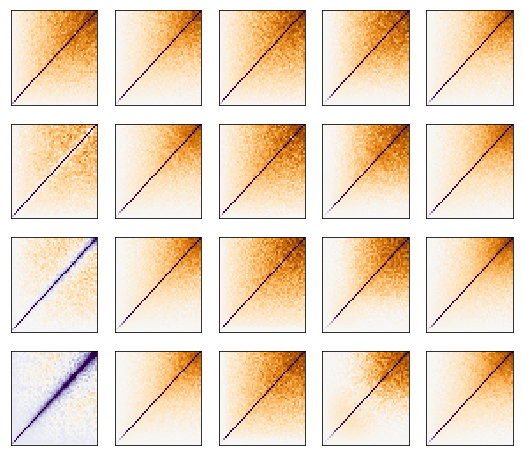

In [185]:
fig = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 1)
    ax.pcolormesh(x, x, PMI_beta[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title('$\alpha={}$'.format(a_list[i]))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 2)
    ax.pcolormesh(x, x, PMI_exp[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 5, 5*(i%4) + 3 + i//4)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])

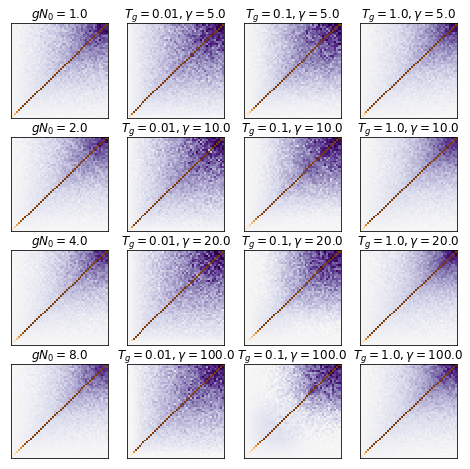

In [399]:
fig = plt.figure(figsize=(8, 8))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 4, 4*i + 1)
    ax.pcolormesh(x, x, PMI_exp[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$gN_0={}$'.format(g_list[i]))

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 4, 4*(i%4) + 2 + i//4)
    ax.pcolormesh(x, x, PMI_pwc[i][0,:,:],
        vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$T_g={}, \gamma={}$'.format(t_list[i//4], 1/s_list[i%4]))

plt.savefig('../manuscript/figures/pmi_growth_r0.pdf')

Combined figure wPMI

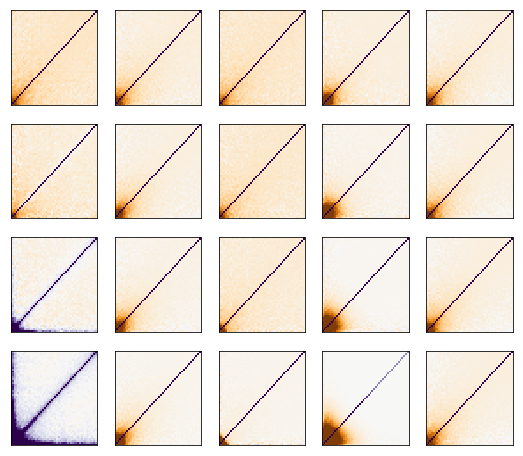

In [377]:
fig = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 1)
    ax.pcolormesh(x, x, wPMI_beta[i][0,:,:]/pi_beta[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title('$\alpha={}$'.format(a_list[i]))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 5, 5*i + 2)
    ax.pcolormesh(x, x, wPMI_exp[i][0,:,:]/pi_exp[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 5, 5*(i%4) + 3 + i//4)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
    ax.set_xticks([])
    ax.set_yticks([])


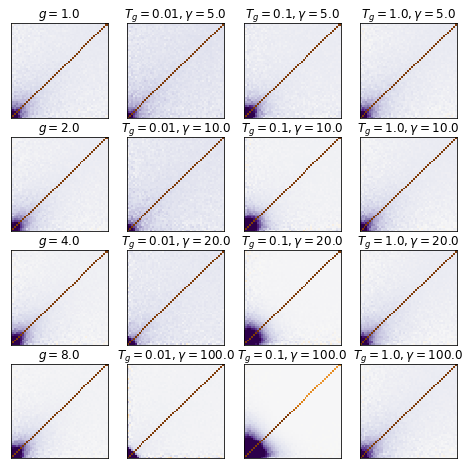

In [380]:
fig = plt.figure(figsize=(8, 8))

# Exponential growth
for i in range(4):
    ax = fig.add_subplot(4, 4, 4*i + 1)
    ax.pcolormesh(x, x, wPMI_exp[i][0,:,:]/pi_exp[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$g={}$'.format(g_list[i]))

# Step growth
for i in range(12):
    ax = fig.add_subplot(4, 4, 4*(i%4) + 2 + i//4)
    ax.pcolormesh(x, x, wPMI_pwc[i][0,:,:]/pi_pwc[i][0]**2,
        vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('$T_g={}, \gamma={}$'.format(t_list[i//4], 1/s_list[i%4]))

plt.savefig('../manuscript/figures/wpmi_growth_r0.pdf')

## Recombining loci

Beta coalescent PMI and wPMI.

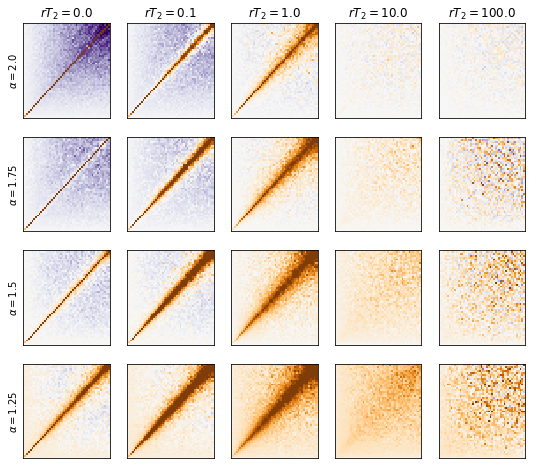

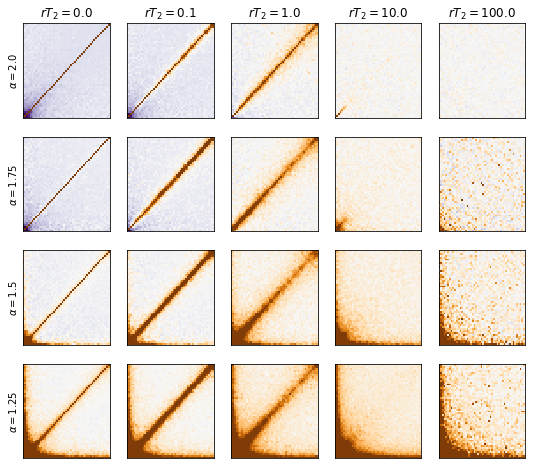

In [395]:
fig1 = plt.figure(figsize=(9, 8))
fig2 = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(4):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        i_r = list(r_list).index(r)
        ax = fig1.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, PMI_beta[i][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(r'$\alpha={}$'.format(a_list[i]))
        if i == 0:
            ax.set_title(r'$rT_2={}$'.format(r_list[i_r]))
        
        ax = fig2.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, wPMI_beta[i][i_r,:,:]/pi_beta[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(r'$\alpha={}$'.format(a_list[i]))
        if i == 0:
            ax.set_title(r'$rT_2={}$'.format(r_list[i_r]))
fig2.savefig('../manuscript/figures/wpmi_beta_r.pdf')

Difference between beta PMI and Kingman PMI unweighted, then weighted.

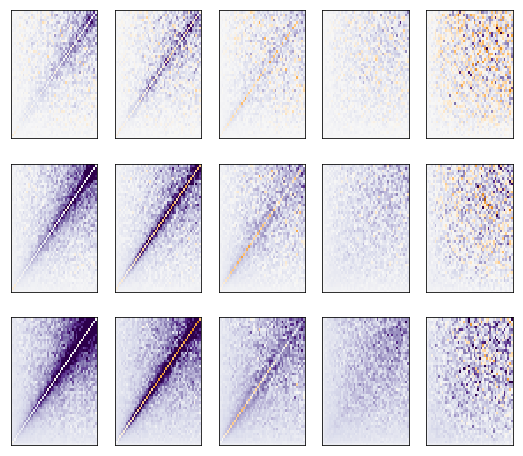

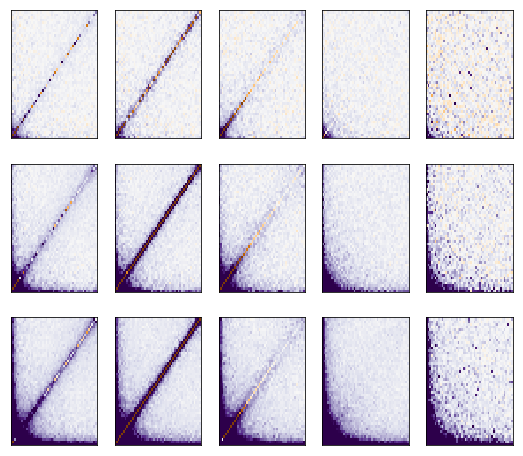

In [140]:
fig1 = plt.figure(figsize=(9, 8))
fig2 = plt.figure(figsize=(9, 8))

# Beta coalescent
for i in range(1,4):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        i_r = list(r_list).index(r)
        ax = fig1.add_subplot(3, 5, 5*(i-1) + col + 1)
        ax.pcolormesh(x, x, PMI_beta[i][i_r,:,:] - PMI_beta[0][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = fig2.add_subplot(3, 5, 5*(i-1) + col + 1)
        ax.pcolormesh(x, x, (PMI_beta[i][i_r,:,:] - PMI_beta[0][i_r,:,:])*
                                jSFS_beta[i][i_r,:,:]/pi_beta[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr')
        ax.set_xticks([])
        ax.set_yticks([])

Exponential growth. Grid by $rho$.

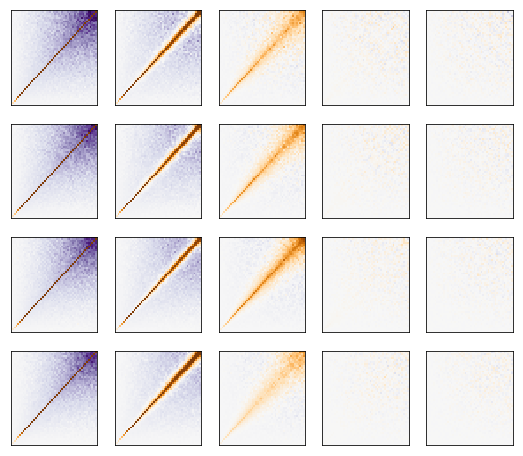

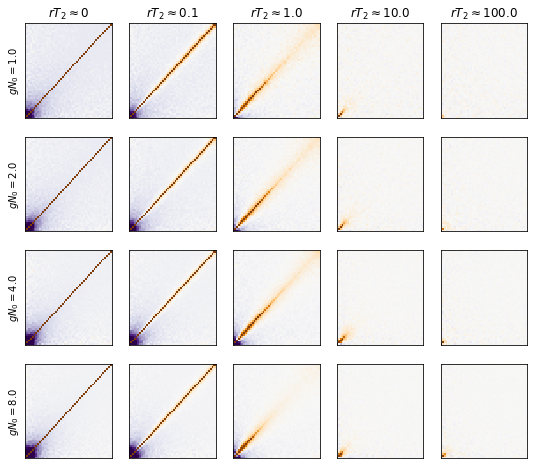

In [400]:
fig1 = plt.figure(figsize=(9, 8))
fig2 = plt.figure(figsize=(9, 8))
for i in range(4):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        rho = r_list[:-3]*pi_exp[i]/2
        i_r = np.argmin(np.abs(rho-r))
        #print(r, rho[i_r])

        #i_r = list(r_list).index(r)
        ax = fig1.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, PMI_exp[i][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = fig2.add_subplot(4, 5, 5*i + col + 1)
        ax.pcolormesh(x, x, wPMI_exp[i][i_r,:,:]/pi_exp[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(r'$gN_0={}$'.format(g_list[i]))
        if i == 0:
            ax.set_title(r'$rT_2 \approx {}$'.format(r))
fig2.savefig('../manuscript/figures/wpmi_exp_r.pdf')

Instantaneous growth. Grid by $\rho$ rather than $r$.

0 0.0
0.1 0.0954766823012
1.0 0.952729044114
10.0 9.5492637062
100.0 95.5969039991
0 0.0
0.1 0.107876411511
1.0 1.07804713831
10.0 10.7987081626
100.0 107.736485542
0 0.0
0.1 0.126720961818
1.0 1.26893924431
10.0 12.6861396733
100.0 58.877520295
0 0.0
0.1 0.0911406196754
1.0 0.911404058214
10.0 9.1188154861
100.0 19.6666996332
0 0.0
0.1 0.126891337548
1.0 1.26898083846
10.0 12.6920153268
100.0 126.820200272
0 0.0
0.1 0.0852864692636
1.0 0.854205598397
10.0 8.53120769444
100.0 85.2950582731
0 0.0
0.1 0.064516240394
1.0 0.645504586566
10.0 6.44833343751
100.0 64.5685219282
0 0.0
0.1 0.103175347517
1.0 1.03146229685
10.0 10.3148077043
100.0 103.165867279
0 0.0
0.1 0.0698873377116
1.0 0.69867819337
10.0 6.98582632155
100.0 69.8399211138
0 0.0
0.1 0.0661944274091
1.0 0.661990799834
10.0 6.62301863418
100.0 66.2172991971
0 0.0
0.1 0.0644407352984
1.0 0.644077888494
10.0 6.4400157188
100.0 64.4138087399
0 0.0
0.1 0.135573336904
1.0 1.35666836548
10.0 13.562292875
100.0 135.581022417


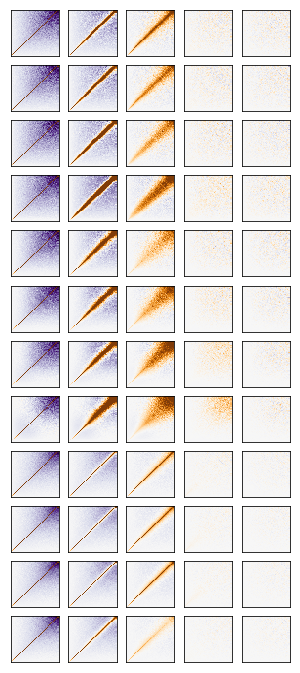

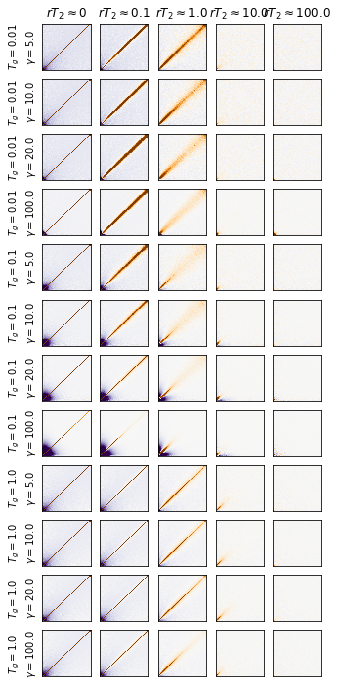

In [441]:
fig1 = plt.figure(figsize=(5, 12))
fig2 = plt.figure(figsize=(5, 12))

n_row = 12
n_col = 5
for i in range(12):
    for col, r in enumerate([0, 0.1, 1.0, 10.0, 100.0]):
        rho = r_list*pi_pwc[i]/2
        i_r = np.argmin(np.abs(rho-r))
        print(r, rho[i_r])

        #i_r = col
        ax = fig1.add_subplot(12, n_col, n_col*i + col + 1)
        ax.pcolormesh(x, x, PMI_pwc[i][i_r,:,:],
            vmin=-pmi_max, vmax=pmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = fig2.add_subplot(12, n_col, n_col*i + col + 1)
        ax.pcolormesh(x, x, wPMI_pwc[i][i_r,:,:]/pi_pwc[i][i_r]**2,
            vmin=-wpmi_max, vmax=wpmi_max, cmap='PuOr_r')
        ax.set_xticks([])
        ax.set_yticks([])
        
        if col == 0:
            ax.set_ylabel('$T_g={}$\n$\gamma={}$'.format(t_list[i//4], 1/s_list[i%4]))
        if i == 0:
            ax.set_title(r'$rT_2 \approx {}$'.format(r))
fig2.savefig('../manuscript/figures/wpmi_step_r.pdf')

## Off-diagonal wPMI

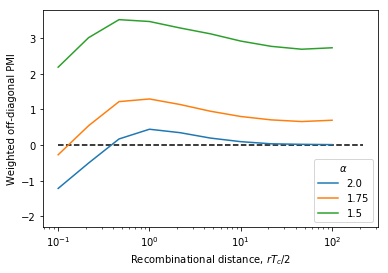

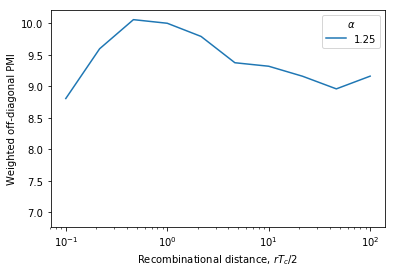

In [144]:
for i,a in enumerate(a_list[:3]):
    plt.semilogx(r_list[:-3], offdiag_beta[i]/pi_beta[i]**2, label=a)
plt.legend(title=r'$\alpha$')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.show()

plt.semilogx(r_list[:-3], offdiag_beta[-1]/pi_beta[-1]**2, label='1.25')
plt.legend(title=r'$\alpha$')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')

(0.09, 110)

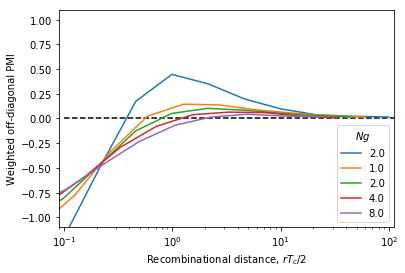

In [149]:
for i,a in enumerate(a_list[:1]):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, offdiag_beta[i]/pi_beta[i]**2, label=a)

for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.1, 1.1])
#plt.ylim([-1.1, 4.1])
plt.xlim([0.09,110])

(0.09, 110)

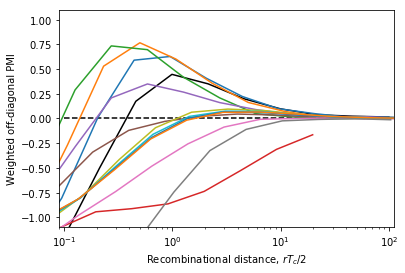

In [192]:
for i,a in enumerate(a_list[:1]):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, offdiag_beta[i]/pi_beta[i]**2, color='k', label=a)

#for i,g in enumerate(g_list):
for i in range(12):
    plt.semilogx(r_list*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2)#, label=g)
#plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.1, 1.1])
#plt.ylim([-1.1, 4.1])
plt.xlim([0.09,110])

(0.09, 110)

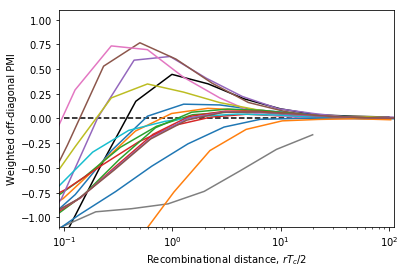

In [193]:
for i,a in enumerate(a_list[:1]):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, offdiag_beta[i]/pi_beta[i]**2, color='k', label=a)

for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2)#, label=g)

for i in range(12):
    plt.semilogx(r_list*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2)#, label=g)
#plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.1, 1.1])
#plt.ylim([-1.1, 4.1])
plt.xlim([0.09,110])

(0.09, 110)

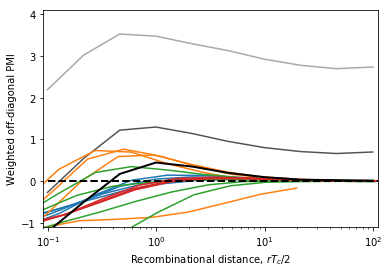

In [316]:
plt.semilogx(r_list[:-3]*pi_beta[0]/2, offdiag_beta[0]/pi_beta[0]**2, color='k', lw=2, zorder=3)
plt.semilogx(r_list[:-3]*pi_beta[1]/2, offdiag_beta[1]/pi_beta[1]**2, color='.33')
plt.semilogx(r_list[:-3]*pi_beta[2]/2, offdiag_beta[2]/pi_beta[2]**2, color='.66')


for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2,
                color='C0') #, alpha=(i+1)/len(g_list))#, label=g)

for i in range(12):
    plt.semilogx(r_list*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2,
                color='C{}'.format(i//4 + 1))#, label=g)
#plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed', lw=2, zorder=3)
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.1, 4.1])
#plt.ylim([-1.1, 4.1])
plt.xlim([0.09,110])

# Singleton-Other correlations

## Proof of concept

In [276]:
def reduce_sfs(SFS, jSFS, cutoff=1):
    n_rows = SFS.shape[0]
    
    r_SFS = np.zeros((n_rows,2))
    r_SFS[:,0] = np.sum(SFS[:,:cutoff], axis=1)
    r_SFS[:,1] = np.sum(SFS[:,cutoff:], axis=1)
    
    r_jSFS = np.zeros((n_rows,2,2))
    r_jSFS[:,0,0] = np.sum(jSFS[:, :cutoff, :cutoff], axis=(1,2))
    r_jSFS[:,0,1] = np.sum(jSFS[:, :cutoff, cutoff:], axis=(1,2))
    r_jSFS[:,1,0] = np.sum(jSFS[:, cutoff:, :cutoff], axis=(1,2))
    r_jSFS[:,1,1] = np.sum(jSFS[:, cutoff:, cutoff:], axis=(1,2))


    #r_jSFS[:,0,1] = np.sum(jSFS[0,1:])
    #r_jSFS[:,1,0] = np.sum(jSFS[1:,0])
    #r_jSFS[:,1,1] = np.sum(jSFS[1:,1:])
    
    #r_pmi = np.log2(r_jSFS/(r_SFS[:,None]*r_SFS[None:]))
    r_PMI = pmi(r_SFS, r_jSFS)
    return r_SFS, r_jSFS, r_PMI

In [277]:
print(mSFS_beta[0].shape)

(11, 50)


In [278]:
rmSFS_k, rjSFS_k, rPMI_k = reduce_sfs(mSFS_beta[0], jSFS_beta[0])
rmSFS_b, rjSFS_b, rPMI_b = reduce_sfs(mSFS_beta[2], jSFS_beta[2])

In [279]:
print(rmSFS_k)
print(rmSFS_b)

[[ 2.01732664  8.33662618]
 [ 2.020316    8.33287882]
 [ 2.02036993  8.33038296]
 [ 2.02167318  8.33793087]
 [ 2.01753417  8.33885691]
 [ 2.01861974  8.34061709]
 [ 2.01735912  8.33556324]
 [ 2.01919505  8.33626141]
 [ 2.01842213  8.33494186]
 [ 2.01922873  8.34144869]
 [ 2.01983434  8.34070485]]
[[ 7.47718057  9.86672618]
 [ 7.4833816   9.87008656]
 [ 7.47434535  9.87498696]
 [ 7.48482884  9.87088511]
 [ 7.47738332  9.88665412]
 [ 7.47570552  9.8567132 ]
 [ 7.4803937   9.86220744]
 [ 7.47912646  9.86505108]
 [ 7.47799205  9.87255493]
 [ 7.48522621  9.85942415]
 [ 7.49258397  9.91626235]]


In [280]:
print(rjSFS_k)
print(rjSFS_b)

[[[  4.48909456  16.64861206]
  [ 16.64861206  75.92339342]]

 [[  4.45429775  16.68945845]
  [ 16.68945845  75.05969873]]

 [[  4.4154483   16.69762831]
  [ 16.69762831  74.4040622 ]]

 [[  4.36564933  16.75843593]
  [ 16.75843593  73.4480603 ]]

 [[  4.27594824  16.75950534]
  [ 16.75950534  72.1996714 ]]

 [[  4.21215915  16.80173681]
  [ 16.80173681  71.09902111]]

 [[  4.16475021  16.79639874]
  [ 16.79639874  70.24854091]]

 [[  4.1349375   16.82519414]
  [ 16.82519414  69.84426652]]

 [[  4.10969121  16.82473086]
  [ 16.82473086  69.57535494]]

 [[  4.09678378  16.84400976]
  [ 16.84400976  69.63143651]]

 [[  4.0927784   16.84105378]
  [ 16.84105378  69.59741047]]]
[[[  58.60588693   74.54319518]
  [  74.54319518  109.44631963]]

 [[  58.45351619   74.71068292]
  [  74.71068292  108.7344663 ]]

 [[  58.14863913   74.75846286]
  [  74.75846286  108.11873347]]

 [[  58.09190296   74.90894375]
  [  74.90894375  107.10370178]]

 [[  57.67011586   75.06979154]
  [  75.06979154  106.

In [281]:
print(rPMI_k)
print(rPMI_b)

[[[  1.41535082e-01  -1.45783422e-02]
  [ -1.45783422e-02   1.27545281e-01]]

 [[  1.26036079e-01  -1.25307239e-02]
  [ -1.25307239e-02   1.12336594e-01]]

 [[  1.13320972e-01  -1.14309989e-02]
  [ -1.14309989e-02   1.00543846e-01]]

 [[  9.50966616e-02  -8.42360134e-03]
  [ -8.42360134e-03   7.92736655e-02]]

 [[  7.10581794e-02  -5.53507446e-03]
  [ -5.53507446e-03   5.42211006e-02]]

 [[  4.78216113e-02  -2.98482845e-03]
  [ -2.98482845e-03   3.14495361e-02]]

 [[  3.32941094e-02  -1.66757777e-03]
  [ -1.66757777e-03   1.58369831e-02]]

 [[  2.03049638e-02  -6.29550890e-04]
  [ -6.29550890e-04   7.26874944e-03]]

 [[  1.25741373e-02   1.11456229e-04]
  [  1.11456229e-04   2.16018766e-03]]

 [[  6.88306118e-03   6.14013628e-05]
  [  6.14013628e-05   1.07095373e-03]]

 [[  4.60660397e-03  -4.95775248e-04]
  [ -4.95775248e-04   6.23108279e-04]]]
[[[ 0.06798494  0.01493891]
  [ 0.01493891  0.16893669]]

 [[ 0.06183722  0.01648956]
  [ 0.01648956  0.15854003]]

 [[ 0.05777907  0.01843893

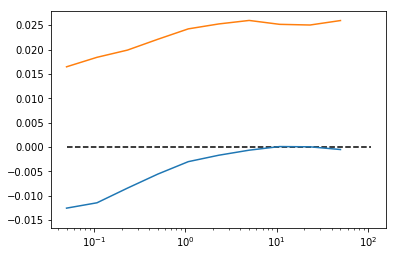

In [288]:
plt.semilogx(r_list[:-3]/2, rPMI_k[:,0,1])
plt.semilogx(r_list[:-3]/2, rPMI_b[:,0,1])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
plt.show()

## Application

In [303]:
rPMI_beta = [reduce_sfs(mSFS_beta[i], jSFS_beta[i])[2] for i in range(len(a_list))]
rPMI_exp = [reduce_sfs(mSFS_exp[i], jSFS_exp[i])[2] for i in range(len(g_list))]
#rPMI_pwc = [reduce_sfs(mSFS_pwc[i], jSFS_pwc[i])[2] for i in range(len(s_list)*len(t_list))]

### Beta coalescent

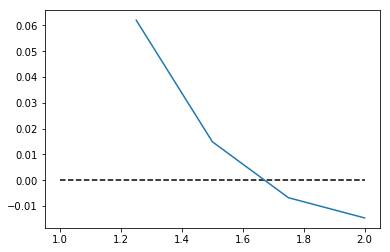

In [297]:
plt.plot(a_list, [rPMI[0,0,1] for rPMI in rPMI_beta])
plt.hlines(0, 1, 2, linestyle='dashed')

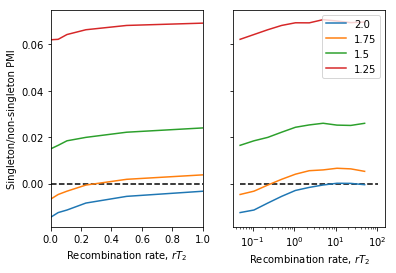

In [413]:
fig = plt.figure()

ax = fig.add_subplot(121)
for rPMI in rPMI_beta:
    plt.plot(r_list[:-3]/2, rPMI[:,0,1])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.set_ylabel('Singleton/non-singleton PMI')

ax = fig.add_subplot(122)
for i, rPMI in enumerate(rPMI_beta):
    plt.semilogx(r_list[:-3]/2, rPMI[:,0,1], label=a_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
ax.set_yticklabels([])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.legend()

fig.savefig('../manuscript/figures/singleton_pmi_beta.pdf')

### Exponential growth

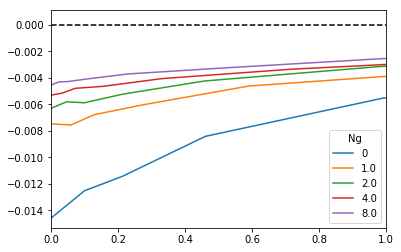

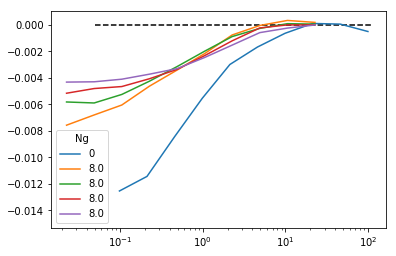

In [310]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_exp):
    plt.plot(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_exp:
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
plt.legend(title='Ng')

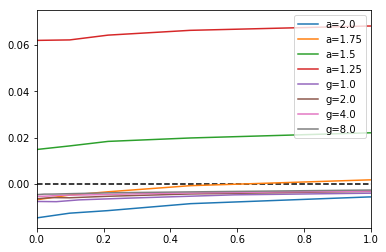

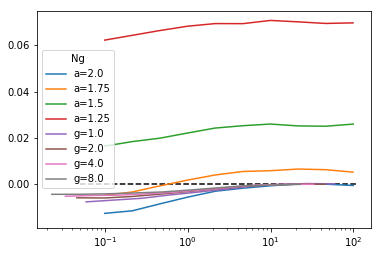

In [313]:
for i, rPMI in enumerate(rPMI_beta):
    plt.plot(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label='a={}'.format(a_list[i]))
for i, rPMI in enumerate(rPMI_exp):
    plt.plot(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label='g={}'.format(g_list[i]))
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
plt.legend()
plt.show()

for i, rPMI in enumerate(rPMI_beta):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label='a={}'.format(a_list[i]))
for i, rPMI in enumerate(rPMI_exp):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], label='g={}'.format(g_list[i]))
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
plt.legend(title='Ng')

### Instantaneous growth

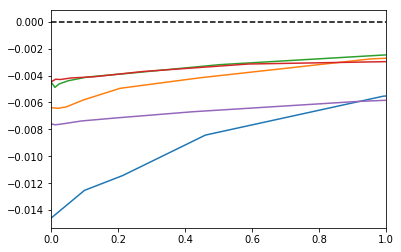

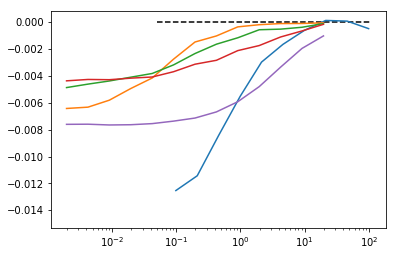

In [319]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_pwc[:4]):
    plt.plot(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
#plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_pwc[:4]:
    plt.semilogx(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
#plt.legend(title='Ng')

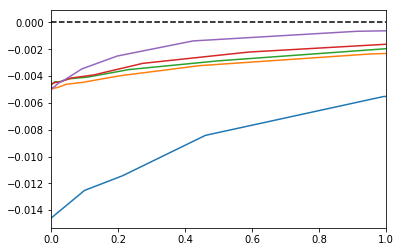

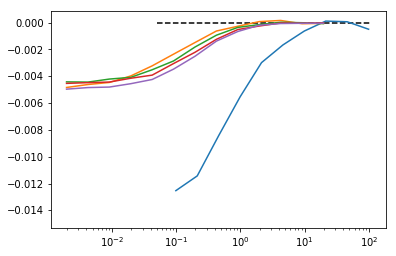

In [320]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_pwc[4:8]):
    plt.plot(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
#plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_pwc[4:8]:
    plt.semilogx(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
#plt.legend(title='Ng')

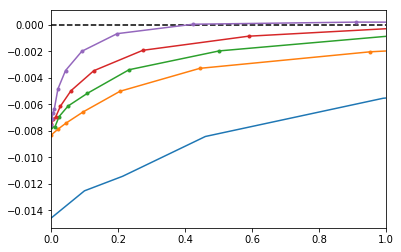

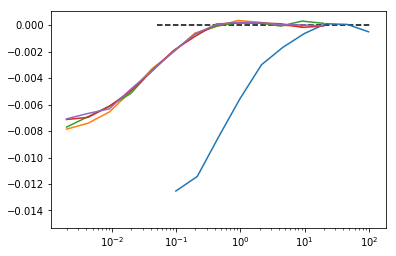

In [326]:
plt.plot(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for i, rPMI in enumerate(rPMI_pwc[8:]):
    plt.plot(r_list*pi_pwc[i]/2, rPMI[:,0,1], '.-')#, label=g_list[i])
plt.hlines(0,0,1, linestyle='dashed')
plt.xlim([0,1])
#plt.legend(title='Ng')
plt.show()

plt.semilogx(r_list[:-3]*pi_beta[0]/2, rPMI_beta[0][:,0,1], label=0)
for rPMI in rPMI_pwc[8:]:
    plt.semilogx(r_list*pi_pwc[i]/2, rPMI[:,0,1])#, label=g_list[i])
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed')
#plt.legend(title='Ng')

In [317]:
for i in range(12):
    print(r_list*pi_pwc[i]/2)

[  0.00000000e+00   2.06056647e-02   4.42621119e-02   9.54766823e-02
   2.05349977e-01   4.43587430e-01   9.52729044e-01   2.05699202e+00
   4.41973525e+00   9.54926371e+00   2.05654188e+01   4.43926352e+01
   9.55969040e+01   2.06208910e+02]
[  0.00000000e+00   1.07719711e-02   2.33164798e-02   5.01399230e-02
   1.07876412e-01   2.32246898e-01   5.01670874e-01   1.07804714e+00
   2.32359112e+00   5.00940880e+00   1.07987082e+01   2.32241762e+01
   5.00304294e+01   1.07736486e+02]
[  0.00000000e+00   5.88641024e-03   1.26569322e-02   2.73131194e-02
   5.88603571e-02   1.26720962e-01   2.73364108e-01   5.88935154e-01
   1.26893924e+00   2.72986028e+00   5.88573662e+00   1.26861397e+01
   2.73281422e+01   5.88775203e+01]
[  0.00000000e+00   1.96615671e-03   4.23912695e-03   9.11052839e-03
   1.96736084e-02   4.23694708e-02   9.11406197e-02   1.96644288e-01
   4.23526644e-01   9.11404058e-01   1.96670824e+00   4.23142249e+00
   9.11881549e+00   1.96666996e+01]
[  0.00000000e+00   2.730075

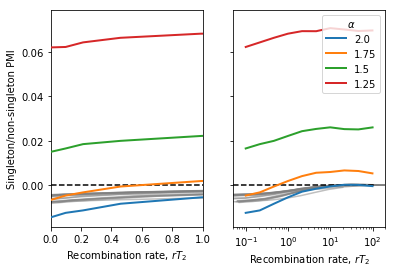

In [440]:
fig = plt.figure()

ax = fig.add_subplot(121)
for i, rPMI in enumerate(rPMI_beta):
    plt.plot(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label=a_list[i], zorder=3, lw=2)
for i, rPMI in enumerate(rPMI_exp):
    plt.plot(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], color='.5', alpha=.5)
for i, rPMI in enumerate(rPMI_pwc):
    plt.plot(r_list*pi_pwc[i]/2, rPMI[:,0,1], color='.5', alpha=.5)

plt.hlines(0,0,1, linestyle='dashed', zorder=3)
plt.xlim([0,1])
ax.set_ylim([-0.019,0.079])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.set_ylabel('Singleton/non-singleton PMI')

ax = fig.add_subplot(122)
for i, rPMI in enumerate(rPMI_beta):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, rPMI[:,0,1], label=a_list[i], zorder=3, lw=2)
for i, rPMI in enumerate(rPMI_exp):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, rPMI[:,0,1], color='.5', alpha=.5)
for i, rPMI in enumerate(rPMI_pwc):
    plt.semilogx(r_list*pi_pwc[i]/2, rPMI[:,0,1], color='.5', alpha=.5)
plt.hlines(0, r_list[1]/2, r_list[-3]/2, linestyle='dashed', zorder=3)
ax.set_xlim([.05,200])
ax.set_ylim([-0.019,0.079])
ax.set_yticklabels([])
ax.set_xlabel('Recombination rate, $rT_2$')
ax.legend(title=r'$\alpha$')
fig.savefig('../manuscript/figures/singleton_pmi_all.pdf')

# Old

In [ ]:
for i,a in enumerate(a_list):
    plt.semilogx(r_list[:-3], diag_beta[i]/pi_beta[i]**2, label=a)
plt.ylabel('Weighted diagonal PMI')
plt.xlabel('Recombinational distance')
plt.legend(title=r'$\alpha$')

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_a, a in enumerate(a_list):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(4, len(r_list)-3, i_a*(len(r_list)-3) + i_r + 1)
        ax.pcolormesh(x, x, PMI_beta[i_a][i_r,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_beta in range(len(PMI_beta)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_beta), len(r_list)-3, i_beta*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_beta[i_beta][i_r,:,:]/pi_beta[i_beta][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_beta[i_beta][i_r]/2))
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_beta in range(len(PMI_beta)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_beta), len(r_list)-3, i_beta*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_beta[i_beta][i_r,:,:]/pi_beta[i_beta][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_beta[i_beta][i_r]/2))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_beta in range(len(PMI_beta)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_beta), len(r_list)-3, i_beta*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_beta[i_beta][i_r,:,:]/pi_beta[i_beta][i_r]**2, vmin=-0.01, vmax=0.01, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_beta[i_beta][i_r]/2))
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_beta in range(len(PMI_beta)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_beta), len(r_list)-3, i_beta*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_beta[i_beta][i_r,:,:]/pi_beta[i_beta][i_r]**2, vmin=-0.01, vmax=0.01, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_beta[i_beta][i_r]/2))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
for i_r, r in enumerate(r_list[:-3]):
    plt.pcolor(x, x, wPMI_beta[1][i_r]/pi_beta[1][i_r]**2 - wPMI_beta[0][i_r]/pi_beta[0][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
    plt.colorbar()
    plt.title(r)
    plt.show()

In [ ]:
for i_r, r in enumerate(r_list[:-3]):
    plt.pcolor(x, x, wPMI_beta[2][i_r]/pi_beta[2][i_r]**2 - wPMI_beta[0][i_r]/pi_beta[0][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
    plt.colorbar()
    plt.title(r)
    plt.show()

## Exponential growth

In [ ]:
g_list = [1.0, 2.0, 4.0, 8.0]

mSFS_exp = []
jSFS_exp = []
pi_exp = []
PMI_exp = []
wPMI_exp = []
diag_exp = []
offdiag_exp = []
for g in g_list:
    file_list = [data_dir + 'jsfs_g-{}_r-{}.txt'.format(g,r) for r in r_list[:-3]]
    mSFS, jSFS = import_sfs(file_list, n_samples)
    pi = np.dot(mSFS, pi_weight)
    PMI = pmi(mSFS, jSFS)
    wPMI = PMI * jSFS
    diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
    offdiag = np.sum(wPMI, axis=(1,2)) - diag
    
    mSFS_exp.append(mSFS)
    jSFS_exp.append(jSFS)
    pi_exp.append(pi)
    PMI_exp.append(PMI)
    wPMI_exp.append(wPMI)
    diag_exp.append(diag)
    offdiag_exp.append(offdiag)

In [ ]:
# Only use thse for posters
import matplotlib as mpl



#mpl.rcParams['axes.linewidth'] = lw
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
#mpl.rcParams['xtick.major.width'] = 3.2
#mpl.rcParams['xtick.minor.width'] = 2.4
#mpl.rcParams['ytick.major.width'] = 3.2
#mpl.rcParams['ytick.minor.width'] = 2.4
#mpl.rcParams['xtick.major.size'] = 7
#mpl.rcParams['xtick.minor.size'] = 4
#mpl.rcParams['ytick.major.size'] = 7
#mpl.rcParams['ytick.minor.size'] = 4

In [ ]:
lw = 4

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.loglog(x[:-1], mSFS_beta[0][0,:-1]/mSFS_beta[0][0,0], lw=lw)
plt.loglog(x[:-1], mSFS_exp[2][0,:-1]/mSFS_exp[2][0,0], lw=lw)
plt.loglog(x[:-1], mSFS_beta[1][0,:-1]/mSFS_beta[1][0,0], lw=lw)
plt.ylim([8e-3, 1.2])
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.semilogx(r_list[:-3]*pi_beta[0]/2, offdiag_beta[0]/pi_beta[0]**2, lw=lw)
plt.semilogx(r_list[:-3]*pi_exp[2]/2, offdiag_exp[2]/pi_exp[2]**2, lw=lw)
plt.semilogx(r_list[:-3]*pi_beta[1]/2, offdiag_beta[1]/pi_beta[1]**2, lw=lw)
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed', lw=lw, zorder=3)
plt.yticks([-1,0,1])
plt.ylim([-1.6,1.6])
plt.xlim([0.09,110])
ax.set_yticklabels([])
ax.set_xticklabels([])



In [ ]:
print(r_list)
print(pi_beta[0])
print(pi_beta[2])
print(pi_exp[2]*r_list[:-3])
print(pi_beta[0]*r_list[:-3])
vmax=1

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(331)
ax.pcolormesh(x, x, PMI_beta[0][0,:,:].T,
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(332)
ax.pcolormesh(x, x, PMI_beta[0][4,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(333)
ax.pcolormesh(x, x, PMI_beta[0][7,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')

ax = plt.subplot(334)
ax.pcolormesh(x, x, PMI_exp[2][0,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(335)
ax.pcolormesh(x, x, PMI_exp[2][4,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(336)
ax.pcolormesh(x, x, PMI_exp[2][7,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')

ax = plt.subplot(337)
ax.pcolormesh(x, x, PMI_beta[2][0,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(338)
ax.pcolormesh(x, x, PMI_beta[2][4,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')
ax = plt.subplot(339)
ax.pcolormesh(x, x, PMI_beta[2][7,:,:],
    vmin=-vmax, vmax=vmax, cmap='PuOr_r')

#ax.set_xscale('log')
#ax.set_yscale('log')
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

(0.09, 110)

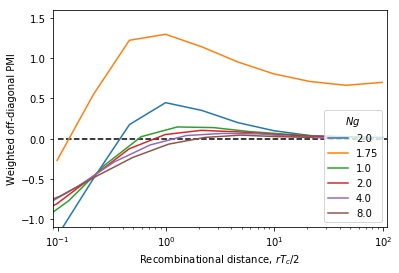

In [145]:
for i,a in enumerate(a_list[:2]):
    plt.semilogx(r_list[:-3]*pi_beta[i]/2, offdiag_beta[i]/pi_beta[i]**2, label=a)

for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.1, 1.6])
plt.xlim([0.09,110])

In [ ]:
for i,a in enumerate(a_list[:2]):
    plt.plot(r_list[:-3], diag_beta[i]/pi_beta[i]**2, label=a)

for i,g in enumerate(g_list):
    plt.plot(r_list[:-3]*pi_exp[i]/2, diag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
#plt.ylim([-1.1, 1.6])
plt.xlim([-.1,1.1])

In [ ]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='0.0')
for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-1.6, 0.6])

In [ ]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='0.0')
for i,g in enumerate(g_list):
    plt.semilogx(r_list[:-3]*pi_exp[i]/2, offdiag_exp[i]/pi_exp[i]**2, label=g)
plt.legend(title=r'$Ng$', loc='upper right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.ylim([-0.1,1.1])
plt.xlim([0.5,500])

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_g, g in enumerate(g_list):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(g_list), len(r_list)-3, i_g*(len(r_list)-3) + i_r + 1)
        ax.pcolormesh(x, x, PMI_exp[i_g][i_r,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
print(g_list)

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_exp in range(len(PMI_exp)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_exp), len(r_list)-3, i_exp*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_exp[i_exp][i_r,:,:]/pi_exp[i_exp][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_exp[i_exp][i_r]/2))
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(11, 4))
for i_exp in range(len(PMI_exp)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_exp), len(r_list)-3, i_exp*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_exp[i_exp][i_r,:,:]/pi_exp[i_exp][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_exp[i_exp][i_r]/2))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

## Piecewise-constant growth

In [ ]:
t_list = [0.01, 0.1, 1.0]
s_list = [0.01, 0.05, 0.1]

mSFS_pwc = []
jSFS_pwc = []
pi_pwc = []
PMI_pwc = []
wPMI_pwc = []
diag_pwc = []
offdiag_pwc = []
for t in t_list:
    for s in s_list:
        file_list = [data_dir + 'jsfs_T-{}_S-{}_r-{}.txt'.format(t,s,r) for r in r_list[:-3]]
        mSFS, jSFS = import_sfs(file_list, n_samples)
        pi = np.dot(mSFS, pi_weight)
        PMI = pmi(mSFS, jSFS)
        wPMI = PMI * jSFS
        diag = np.sum(np.diagonal(wPMI, axis1=1, axis2=2), axis=1)
        offdiag = np.sum(wPMI, axis=(1,2)) - diag

        mSFS_pwc.append(mSFS)
        jSFS_pwc.append(jSFS)
        pi_pwc.append(pi)
        PMI_pwc.append(PMI)
        wPMI_pwc.append(wPMI)
        diag_pwc.append(diag)
        offdiag_pwc.append(offdiag)

In [ ]:
print(len(PMI_pwc))

In [ ]:
print(pi_pwc)

In [ ]:
fig = plt.figure(figsize=(11, 9))
for i_pwc in range(len(PMI_pwc)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_pwc), len(r_list)-3, i_pwc*(len(r_list)-3) + i_r + 1)
        ax.pcolormesh(x, x, PMI_pwc[i_pwc][i_r,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_pwc[i_pwc][i_r]/2))
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
fig = plt.figure(figsize=(11, 9))
for i_pwc in range(len(PMI_pwc)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_pwc), len(r_list)-3, i_pwc*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_pwc[i_pwc][i_r,:,:]/pi_pwc[i_pwc][i_r]**2, vmin=-0.01, vmax=0.01, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_pwc[i_pwc][i_r]/2))
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(11, 9))
for i_pwc in range(len(PMI_pwc)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_pwc), len(r_list)-3, i_pwc*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_pwc[i_pwc][i_r,:,:]/pi_pwc[i_pwc][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_pwc[i_pwc][i_r]/2))
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(11, 9))
for i_pwc in range(len(PMI_pwc)):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(len(PMI_pwc), len(r_list)-3, i_pwc*(len(r_list)-3) + i_r + 1)
        plt.pcolor(x, x, wPMI_pwc[i_pwc][i_r,:,:]/pi_pwc[i_pwc][i_r]**2, vmin=-0.001, vmax=0.001, cmap='PuOr')
        ax.set_title("{:.1}".format(r_list[i_r]*pi_pwc[i_pwc][i_r]/2))
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])
#plt.colorbar()

In [ ]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='1.0')
for i in range(3)[::-1]:
    plt.semilogx(r_list[:-3]*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2, label=1.0/s_list[i])
plt.legend(title='Growth factor', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.title(r'Growth at $T=T_c/100$')
#plt.ylim([-1.6, 0.6])

In [ ]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='1.0')
for i in range(3,6)[::-1]:
    plt.semilogx(r_list[:-3]*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2, label=1.0/s_list[i%3])
plt.legend(title='Growth factor', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.title(r'Growth at $T=T_c/10$')
#plt.ylim([-1.6, 0.6])

In [ ]:
plt.semilogx(r_list*pi_kingman/2, offdiag_kingman/pi_kingman**2, label='1.0')
for i in range(6,9)[::-1]:
    plt.semilogx(r_list[:-3]*pi_pwc[i]/2, offdiag_pwc[i]/pi_pwc[i]**2, label=1.0/s_list[i%3])
plt.legend(title='Growth factor', loc='lower right')
plt.hlines(0, r_list[1], r_list[-3], linestyle='dashed')
plt.ylabel('Weighted off-diagonal PMI')
plt.xlabel('Recombinational distance, $rT_c/2$')
plt.title(r'Growth at $T=T_c$')
#plt.ylim([-1.6, 0.6])

In [ ]:
fig = plt.figure(figsize=(11, 1))
for i_r, r in enumerate(r_list[:-3]):
    ax = fig.add_subplot(1, len(r_list)-3, i_r + 1)
    ax.pcolormesh(x, x, PMI_kingman[i_r,:,:],
        vmin=-1, vmax=1, cmap='PuOr')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
fig = plt.figure(figsize=(11, 9))
for i in range(9):
    for i_r, r in enumerate(r_list[:-3]):
        ax = fig.add_subplot(9, len(r_list)-3, i*(len(r_list)-3) + i_r + 1)
        ax.pcolormesh(x, x, PMI_pwc[i][i_r,:,:],
            vmin=-1, vmax=1, cmap='PuOr')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
print([p[0] for p in pi_pwc])

## Bolthausen-Sznitman Coalescent

In [ ]:
sim = 'a-1.01'
mMAF = np.zeros((len(r_list), n_samples-1))
jMAF_triu = np.zeros((len(r_list), n_samples*(n_samples-1)//2))
for i, r in enumerate(r_list):
    filecount = 0.0
    for rep in range(10):
        fn = 'jsfs_{}_r-{}_rep-{}.txt'.format(sim, r, rep)
        try:
            datafile = open(data_dir + fn)
        except FileNotFoundError:
            continue
        filecount += 1
        for line in datafile:
            if line.startswith('#'):
                continue
            else:
                mMAF[i,:] += np.array(line.split(), dtype=float)
                jMAF_triu[i,:] += np.array(datafile.readline().split(), dtype=float)
                break
        datafile.close()
    mMAF[i,:] /= filecount
    jMAF_triu[i,:] /= filecount
                
jMAF = np.zeros((len(r_list), n_samples-1, n_samples-1))
for i in range(len(r_list)):
    jMAF[i,:,:][np.triu_indices(n_samples-1)] = jMAF_triu[i,:]
    jMAF[i,:,:][np.diag_indices(n_samples-1)] /= 2
jMAF += np.transpose(jMAF, axes=(0,2,1))

x_fold = x[:n_samples//2]
mMAF_fold = (mMAF + mMAF[:,::-1])[:,:n_samples//2]
mMAF_fold[:,-1] /= 2

jMAF_fold = (jMAF + jMAF[:,::-1,:] + jMAF[:,:,::-1] + jMAF[:,::-1,::-1])[:, :n_samples//2, :n_samples//2]
jMAF_fold[:,-1,:-1] /= 2
jMAF_fold[:,:-1,-1] /= 2
jMAF_fold[:,-1,-1] /= 4


mMAF_sq_fold = mMAF_fold[:,:,None] * mMAF_fold[:,None,:]
ratio_fold = jMAF_fold / mMAF_sq_fold

jMAF_bsc = jMAF_fold
mMAF_bsc = mMAF_fold
pi_bsc = np.dot(mMAF_fold, pi_weight)
#PMI_bsc = jMAF_fold * np.log2(ratio_fold)
PMI_bsc = np.log2(ratio_fold)
wPMI_bsc = jMAF_bsc*PMI_bsc
diag_bsc = np.sum(np.diagonal(wPMI_bsc, axis1=1, axis2=2), axis=1)
offdiag_bsc = np.sum(wPMI_bsc, axis=(1,2)) - diag_bsc

In [ ]:
plt.semilogx(r_list*pi_bsc/2, offdiag_bsc/pi_bsc**2)
#print(r_list.shape, pi_bsc.shape, offdiag_bsc.shape)